<a href="https://colab.research.google.com/github/yatora200403/citrus-orange-disease-detection/blob/main/Deteksi_Penyakit_jeruk_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the requirements

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fajard","key":"91dc02fae48ac8797a1fcd9ac2e1ec4f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'jonathansilva2020/orange-diseases-dataset'

Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 64% 89.0M/138M [00:00<00:00, 933MB/s]
100% 138M/138M [00:00<00:00, 703MB/s] 


<h2>Extract Dataset</h2>

In [ ]:
# Import library untuk handling zip file
import zipfile

In [ ]:
# Spesifikan  nama file
dataset_zip = zipfile.ZipFile('orange-diseases-dataset.zip','r')

# Extract
dataset_zip.extractall('orange-diseases-dataset')

# Tutup zip file
dataset_zip.close()

## View the dataset

In [ ]:
from PIL import Image

# Fungsi untuk memuat dan mengubah ukuran gambar menggunakan PIL
def load_and_resize_image(file_path, target_shape=(224, 224)):
    image = Image.open(file_path).convert('RGB')  # Membuka gambar dan mengonversi ke RGB
    resized_image = image.resize(target_shape)   # Mengubah ukuran gambar
    return np.array(resized_image)               # Mengembalikan gambar dalam bentuk array

In [ ]:
# Fungsi untuk memuat gambar dari direktori
def load_image_class_by_directory(image_dir):
    # Daftar file gambar di dalam direktori
    image_files = [file for file in os.listdir(image_dir) if file.lower().endswith('.jpg') or file.lower().endswith('.png')]
    images = [load_and_resize_image(os.path.join(image_dir, file)) for file in image_files]

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [ ]:
# Menampilkan beberapa gambar
def display_images(images, num_images_to_display=6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

In [ ]:
# import shutil
# shutil.rmtree('/content/orange-diseases-dataset')

#mengganti nama folder yang tidak sesuai
old_names = ['blackspot', 'canker', 'grenning', 'fresh']
new_names = ['blackspot', 'cancer', 'greening', 'fresh']
train_path = '/content/orange-diseases-dataset/train/'
test_path = '/content/orange-diseases-dataset/test/'
for i,name in enumerate(old_names):
  os.rename(os.path.join(train_path, name), os.path.join(train_path,new_names[i]))
  os.rename(os.path.join(test_path, name), os.path.join(test_path,new_names[i]))

In [ ]:
#convert png to jpg
from PIL import Image

def convert_png_to_jpg(path):
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      img = img.convert('RGB')
      img.save(os.path.join(path, os.path.splitext(filename)[0] + '.jpg'))
      os.remove(os.path.join(path, filename))

fresh_train = '/content/orange-diseases-dataset/train/fresh/'
fresh_test = '/content/orange-diseases-dataset/test/fresh/'
convert_png_to_jpg(fresh_train)
convert_png_to_jpg(fresh_test)

Class **1** Sample (Blackspot)

Num of images: 184
Single image shape before flattening: (224, 224, 3)


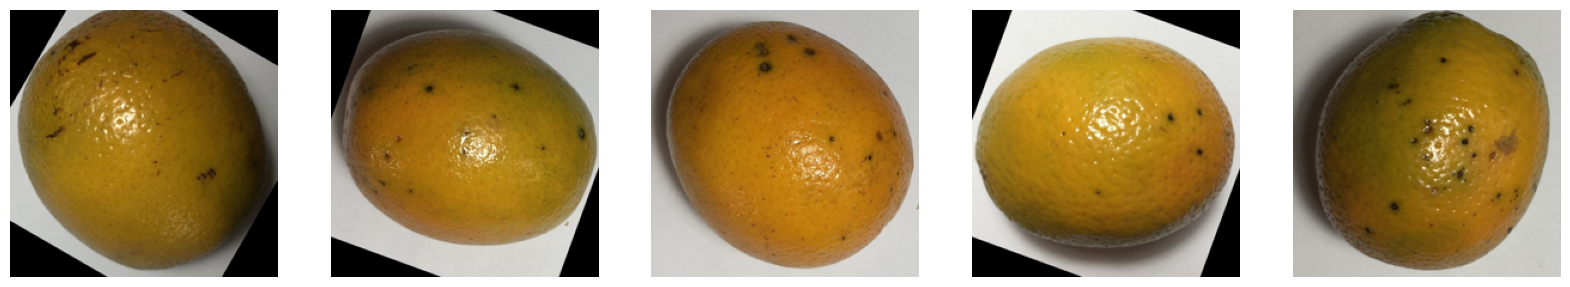

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/blackspot'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 2 Sample (Cancer)

Num of images: 179
Single image shape before flattening: (224, 224, 3)


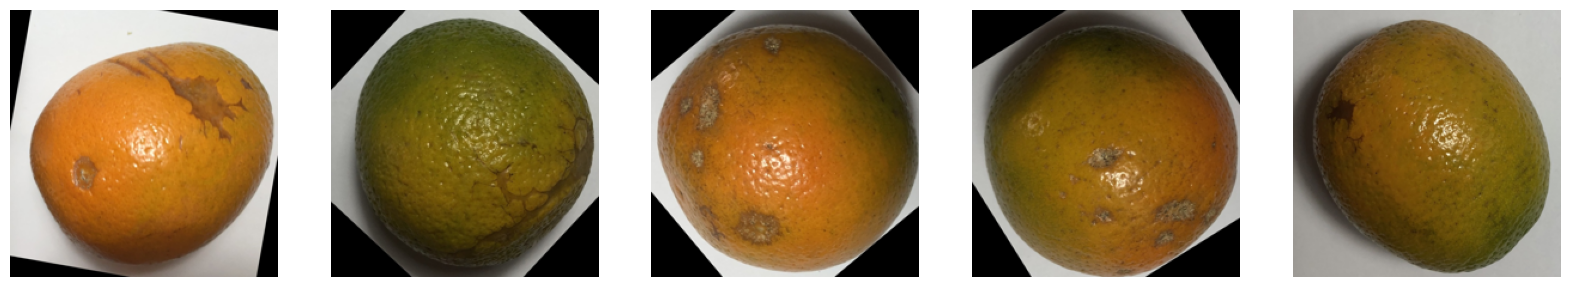

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/cancer'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 3 Sample (Greening)

Num of images: 347
Single image shape before flattening: (224, 224, 3)


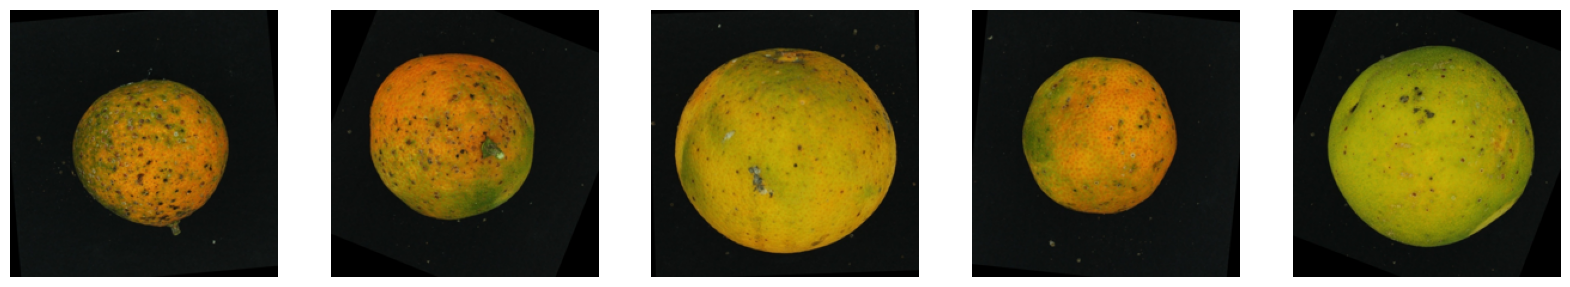

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/greening'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 4 Sample (Fresh)

Num of images: 281
Single image shape before flattening: (224, 224, 3)


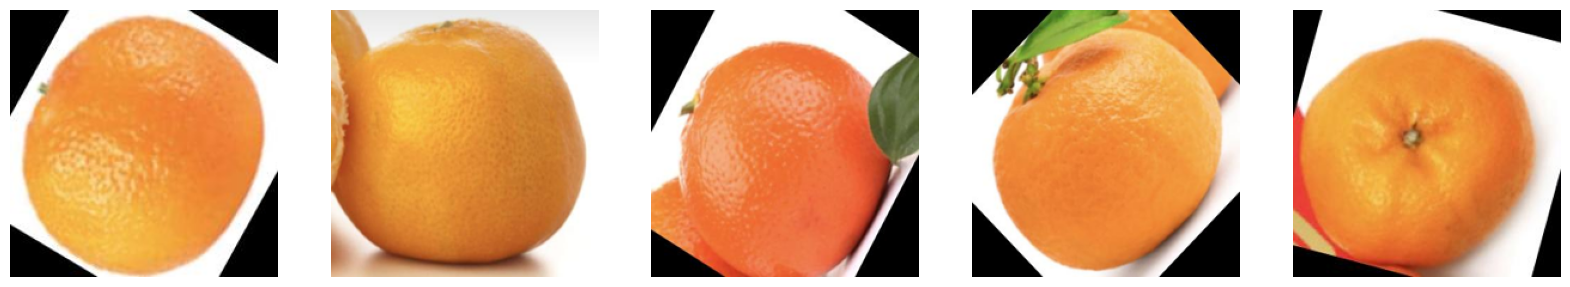

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

In [ ]:
def count_images_in_classes(base_dir):
    # Daftar semua subfolder dalam base_dir
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Iterasi untuk menghitung jumlah gambar setiap kelas
    for class_name in class_dirs:
        class_path = os.path.join(base_dir, class_name)
        # Hitung file dengan ekstensi .jpg atau .png
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')])
        print(f"Disease: {class_name} --- Images: {num_images}")

# Path menuju direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

count_images_in_classes(base_dir)

Disease: blackspot --- Images: 184
Disease: fresh --- Images: 281
Disease: greening --- Images: 347
Disease: cancer --- Images: 179


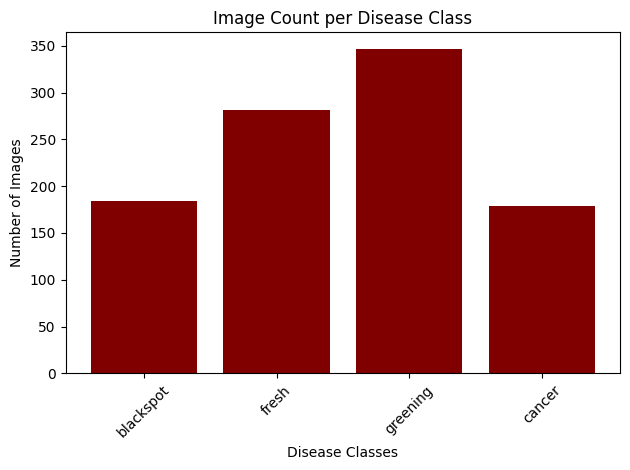

In [ ]:
def count_images_and_plot(base_dir):
    # Hitung jumlah gambar per kelas
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    class_counts = [len([f for f in os.listdir(os.path.join(base_dir, d)) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]) for d in class_dirs]

    # Buat chart
    plt.bar(class_dirs, class_counts, color='maroon')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Disease Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path menuju ke direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

# Hitung dan juga tampilkan chart
count_images_and_plot(base_dir)

# Preprocessing

## Data Augmentation

In [ ]:
def image_aug(path, img_class:str):
  img_list = []
  for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_list.append(img_array)


  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True
  )

  for img in img_list:
    img = img.reshape((1,) + img.shape)
    for batch in datagen.flow(img, batch_size=1, save_to_dir='/content/orange-diseases-dataset/train/'+img_class, save_prefix=img_class, save_format='jpg'):
      if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
        break
    if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
      break

disease_classes = ['blackspot','cancer','greening','fresh']
for disease in disease_classes:
  image_aug('/content/orange-diseases-dataset/train/'+disease, disease)

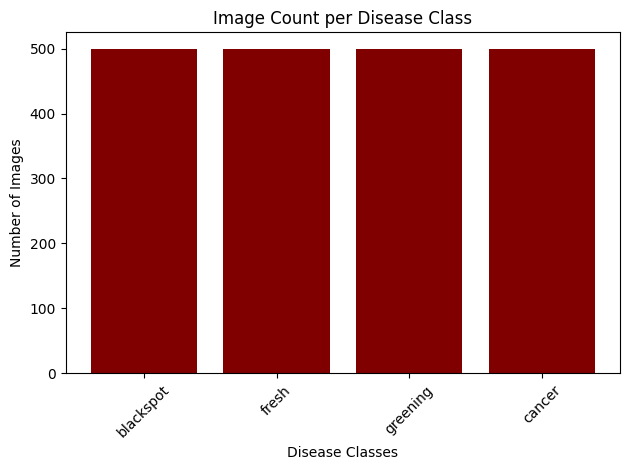

In [ ]:
count_images_and_plot(base_dir)
# plt.imshow(Image.open('/content/orange-diseases-dataset/train/blackspot/blackspot_0_150.jpg'))
# plt.axis('off')
# plt.show()

## Image Normalization

Found 991 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Num of images: 281
Single image shape before flattening: (224, 224, 3)


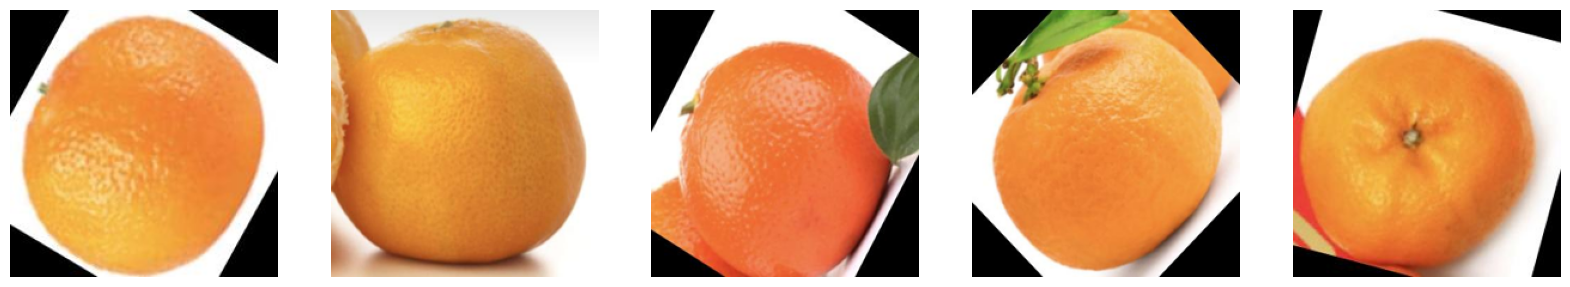

In [ ]:
datagen_normalized = ImageDataGenerator(rescale=1./255)

train_generator_normalized = datagen_normalized.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator_normalized = datagen_normalized.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

## Splitting Dataset into:

<ul>
  <li>training = 70%</li>
  <li>validation = 15%</li>
  <li>test = 15%</li>
</ul>

In [ ]:
dataset_path = Path('/content/orange-diseases-dataset/train')
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
#store all name of disease class names
class_names = train_ds.class_names

# Further split the validation dataset to create a test dataset
val_batches = int(0.5 * val_ds.cardinality().numpy())
valid_ds = val_ds.take(val_batches)
test_ds = val_ds.skip(val_batches)

# Print dataset information
print(f"Training batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {valid_ds.cardinality().numpy()}")
print(f"Testing batches: {test_ds.cardinality().numpy()}")


Found 2000 files belonging to 4 classes.
Using 1400 files for training.
Found 2000 files belonging to 4 classes.
Using 600 files for validation.
Training batches: 44
Validation batches: 9
Testing batches: 10


# Training Process

## MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,452 (10.04 MB)

 Trainable params: 371,908 (1.42 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.5131 - loss: 1.1453 - val_accuracy: 0.8090 - val_loss: 0.7623
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8844 - loss: 0.3767 - val_accuracy: 0.9097 - val_loss: 0.4219
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9096 - loss: 0.2202 - val_accuracy: 0.9201 - val_loss: 0.2574
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9258 - loss: 0.1740 - val_accuracy: 0.9375 - val_loss: 0.1860
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9520 - loss: 0.1409 - val_accuracy: 0.9062 - val_loss: 0.1729
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9412 - loss: 0.1312 - val_accuracy: 0.9340 - val_loss: 0.1272
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9511 - loss: 0.1149 - val_accuracy: 0.9618 - val_loss: 0.0913
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9626 - loss: 0.0950 - val_accuracy: 0.9549

# Training Performace

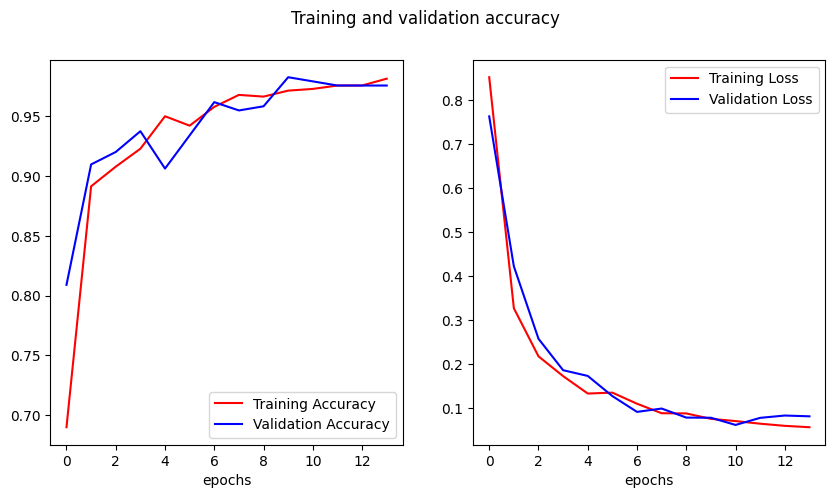

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## y_true and y_pred

In [ ]:
y_true = []
y_pred = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


## Recall

In [ ]:
test_loss, test_acc = model.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9905 - loss: 0.0410
Test Accuracy: 0.9900000095367432
Test Loss: 0.039935532957315445


## Precission

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")

Precision: 0.967948717948718


## F1-score

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")

F1 Score: 0.967948717948718


## Confusion matrix

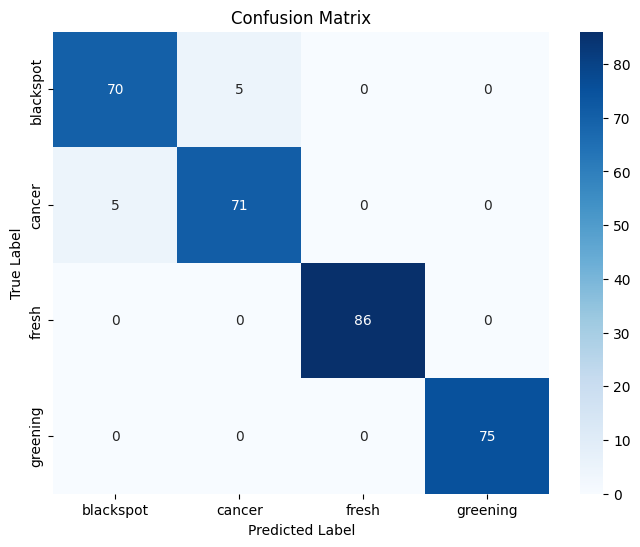

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Test and save model

## train_ds

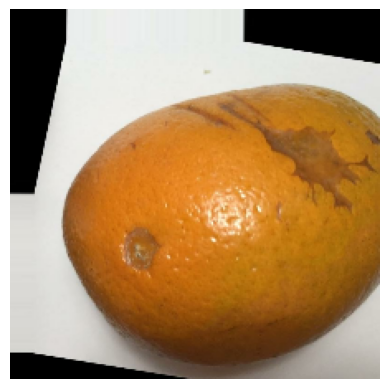

Label: cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: cancer
Confidence: 100.00%
Prediction: [[1.2776177e-06 9.9998891e-01 9.8294631e-06 3.1473260e-08]]


In [ ]:
#test model using train_ds
def get_image_by_index(dataset, index):
  for i, (image, label) in enumerate(dataset):
    if i == index:
      return image[0], label[0]
  return None, None

index = 3
image, label = get_image_by_index(train_ds, index)

if image is not None:
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
  plt.axis('off')
  plt.show()
  print(f"Label: {class_names[label]}")
  prediction = model.predict(np.expand_dims(image, axis=0))
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction[0]) * 100

  print(f"Predicted Class: {predicted_class}")
  print(f"Confidence: {confidence:.2f}%")
  print(f"Prediction: {prediction}")
else:
  print("Image not found in the dataset.")


## test_ds

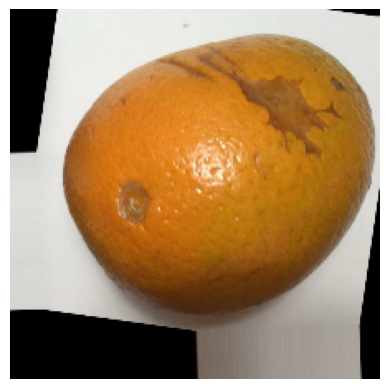

Label: cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: cancer
Confidence: 100.00%
Prediction: [[1.2637572e-05 9.9998558e-01 1.8423918e-06 2.8093092e-08]]


In [ ]:
def get_image_by_index(dataset, index):
  for i, (image, label) in enumerate(dataset):
    if i == index:
      return image[0], label[0]
  return None, None

index = 2
image, label = get_image_by_index(test_ds, index)

if image is not None:
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
  plt.axis('off')
  plt.show()
  print(f"Label: {class_names[label]}")
  prediction = model.predict(np.expand_dims(image, axis=0))
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction[0]) * 100

  print(f"Predicted Class: {predicted_class}")
  print(f"Confidence: {confidence:.2f}%")
  print(f"Prediction: {prediction}")
else:
  print("Image not found in the dataset.")

## save model

In [ ]:
# save model
model.save('citrus-orange-model.keras')

## example for test using saved model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# load model
loaded_model = tf.keras.models.load_model('citrus-orange-model.keras')

def get_image_by_index(dataset, index):
  for i, (image, label) in enumerate(dataset):
    if i == index:
      return image[0], label[0]
  return None, None

index = 5
image, label = get_image_by_index(test_ds, index)

if image is not None:
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
  plt.axis('off')
  plt.show()
  print(f"Label: {class_names[label]}")
  prediction = loaded_model.predict(np.expand_dims(image, axis=0))
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction[0]) * 100

  print(f"Predicted Class: {predicted_class}")
  print(f"Confidence: {confidence:.2f}%")
  print(f"Prediction: {prediction}")
else:
  print("Image not found in the dataset.")